# Generalized Hodgkins-Huxley model for a bursting neuron

Jared Callaham (2020)



In [20]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import SparsePCA

import matplotlib as mpl
mpl.rc('text', usetex=True)
mpl.rc('font', family='serif')
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', labelsize=20)
mpl.rc('axes', titlesize=20)
mpl.rc('figure', figsize=(12, 8))
%config InlineBackend.figure_format = 'retina'

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

# colorbrewer2 colormap
# Swap orange and red for better visibility
cb2_list = ['#ffffff', '#f781bf','#377eb8','#4daf4a','#984ea3','#ff7f00','#a65628','#e41a1c','#999999','#000000']
cb2_cmap = ListedColormap(cb2_list)

cm = cb2_cmap

## Load bursting data (from MATLAB sim)

In [9]:
data = sio.loadmat('./data/burst_data.mat')
print(data.keys())

V = data['V']
t = data['time']

# Post transient
idx = (t>6)
V = V[idx]
t = t[idx]
t = t-t[0]

dict_keys(['__header__', '__version__', '__globals__', 'Cm', 'ICa', 'ICaP', 'IISI', 'IK', 'IL', 'INS', 'INa', 'INaCa', 'INaK', 'IR', 'V', 'dV', 'time'])


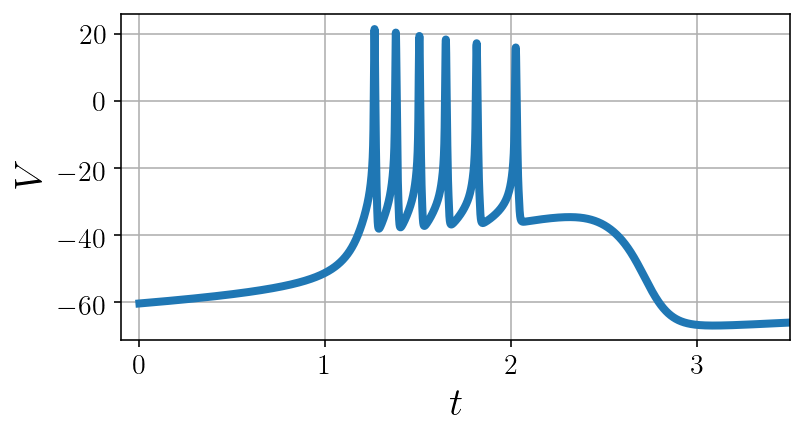

In [10]:
plt.figure(figsize=(6, 3))
plt.plot(t, V, lw=4)
    
plt.xlabel('$t$')
plt.ylabel(r'$V$')
plt.grid()

plt.xlim([-.1, 3.5])

plt.gca().set_axisbelow(True)
plt.show()

# 1. Equation space representation

In [11]:
labels = [r'$\dot{V}$', r'$I_\mathrm{Ca}$', r'$I_\mathrm{CaP}$', r'$I_\mathrm{SI}$', \
          r'$I_\mathrm{K}$', r'$I_\mathrm{L}$', r'$I_\mathrm{R}$', r'$I_\mathrm{NS}$', \
          r'$I_\mathrm{Na}$', r'$I_\mathrm{NaCa}$', r'$I_\mathrm{NaK}$']
nfeatures = len(labels)

features = np.zeros((len(t), nfeatures))
features[:, 0] = data['dV'][idx]*data['Cm'][0][0]
features[:, 1] = data['ICa'][idx]
features[:, 2] = data['ICaP'][idx]
features[:, 3] = data['IISI'][idx]
features[:, 4] = data['IK'][idx]
features[:, 5] = data['IL'][idx]
features[:, 6] = data['IR'][idx]
features[:, 7] = data['INS'][idx]
features[:, 8] = data['INa'][idx]
features[:, 9] = data['INaCa'][idx]
features[:, 10] = data['INaK'][0, 0] + 0*t  # Scalar valued

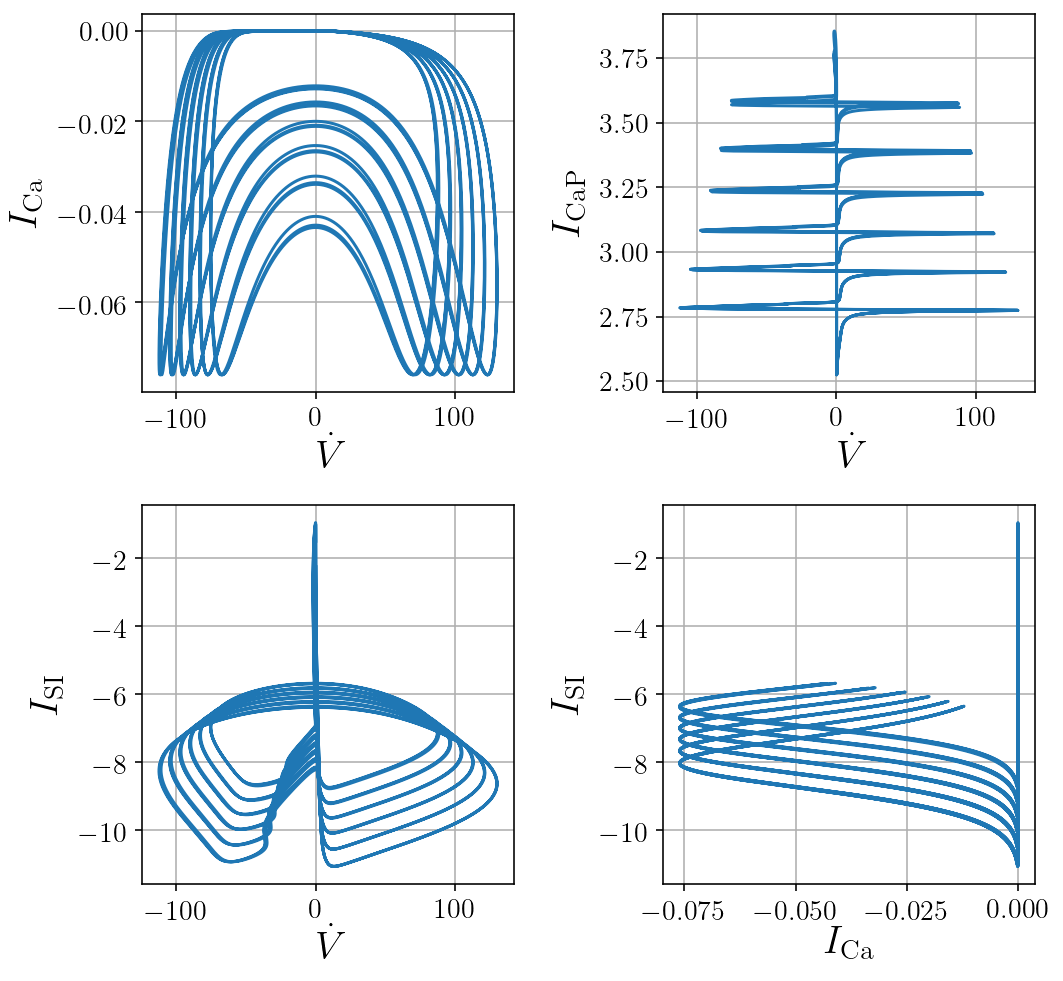

In [12]:
# Equation space terms

plt.figure(figsize=(8, 8))

plt.subplot(221)
plt.plot(features[:, 0], features[:, 1])
plt.xlabel(labels[0])
plt.ylabel(labels[1])
plt.grid()

plt.subplot(222)
plt.plot(features[:, 0], features[:, 2])
plt.xlabel(labels[0])
plt.ylabel(labels[2])
plt.grid()

plt.subplot(223)
plt.plot(features[:, 0], features[:, 3])
plt.xlabel(labels[0])
plt.ylabel(labels[3])
plt.grid()

plt.subplot(224)
plt.plot(features[:, 1], features[:, 3])
plt.xlabel(labels[1])
plt.ylabel(labels[3])
plt.grid()

plt.subplots_adjust(hspace=0.3, wspace=0.4)
plt.show()

# 2. Gaussian mixture model

In [14]:
# Train Gaussian mixture model
nc = 9  # Number of clusters

seed = np.random.randint(2**32)
seed = 3040432755   # Standard seed for debugging/plotting
print(seed)
model = GaussianMixture(n_components=nc, random_state=seed, max_iter=1000, n_init=1)

# Subsample model for faster training
model.fit(features[::10, :])
# "Predict" clusters
cluster_idx = model.predict(features)

3040432755


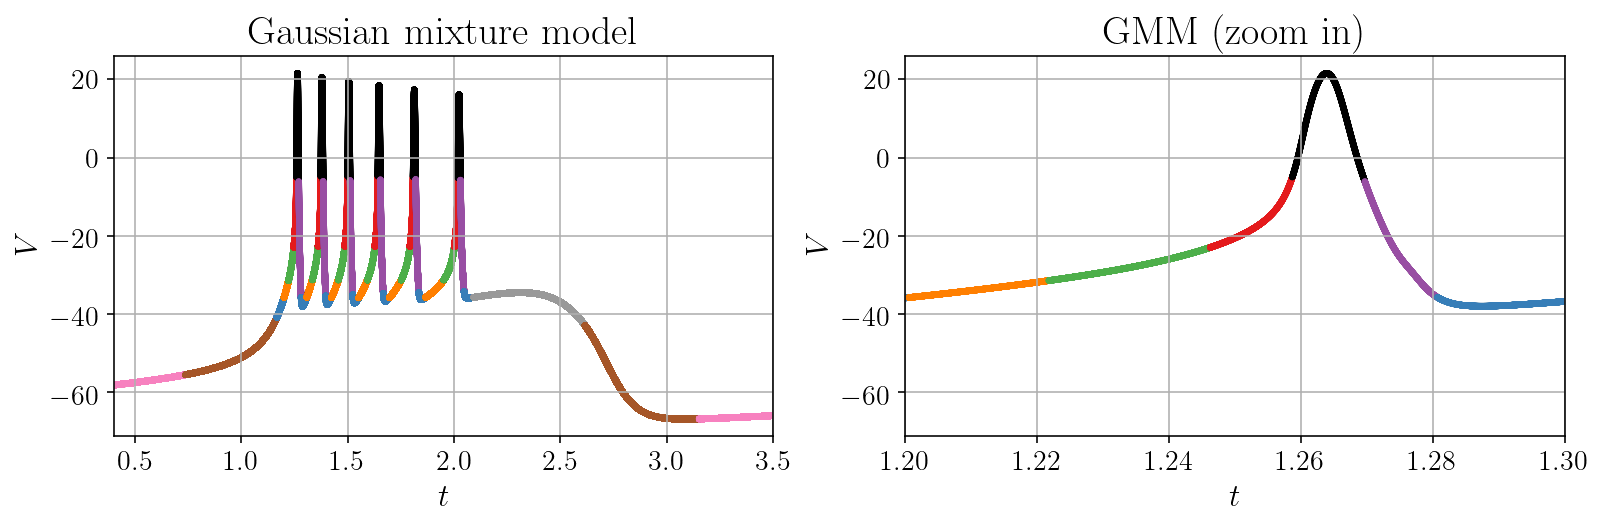

In [22]:
s=5

plot_idx = (t<1.3)*(t>1.2)

plt.figure(figsize=(13, 3.5))

plt.subplot(121)
plot_idx = (t<3.5)*(t>0.4)
plt.scatter(t[plot_idx], V[plot_idx], s, cluster_idx[plot_idx]+1, cmap=cm)
plt.clim([-0.5, cm.N-0.5])
plt.xlim([0.4, 3.5])

plt.xlabel('$t$', fontsize=16)
plt.ylabel(r'$V$', fontsize=16)
plt.title('Gaussian mixture model')
plt.grid()

plt.subplot(122)
plt.scatter(t[plot_idx], V[plot_idx], s, cluster_idx[plot_idx]+1, cmap=cm)
plt.clim([-0.5, cm.N-0.5])
plt.xlim([1.2, 1.3])

plt.xlabel('$t$', fontsize=16)
plt.ylabel(r'$V$', fontsize=16)
plt.grid()
plt.title('GMM (zoom in)')

plt.show()

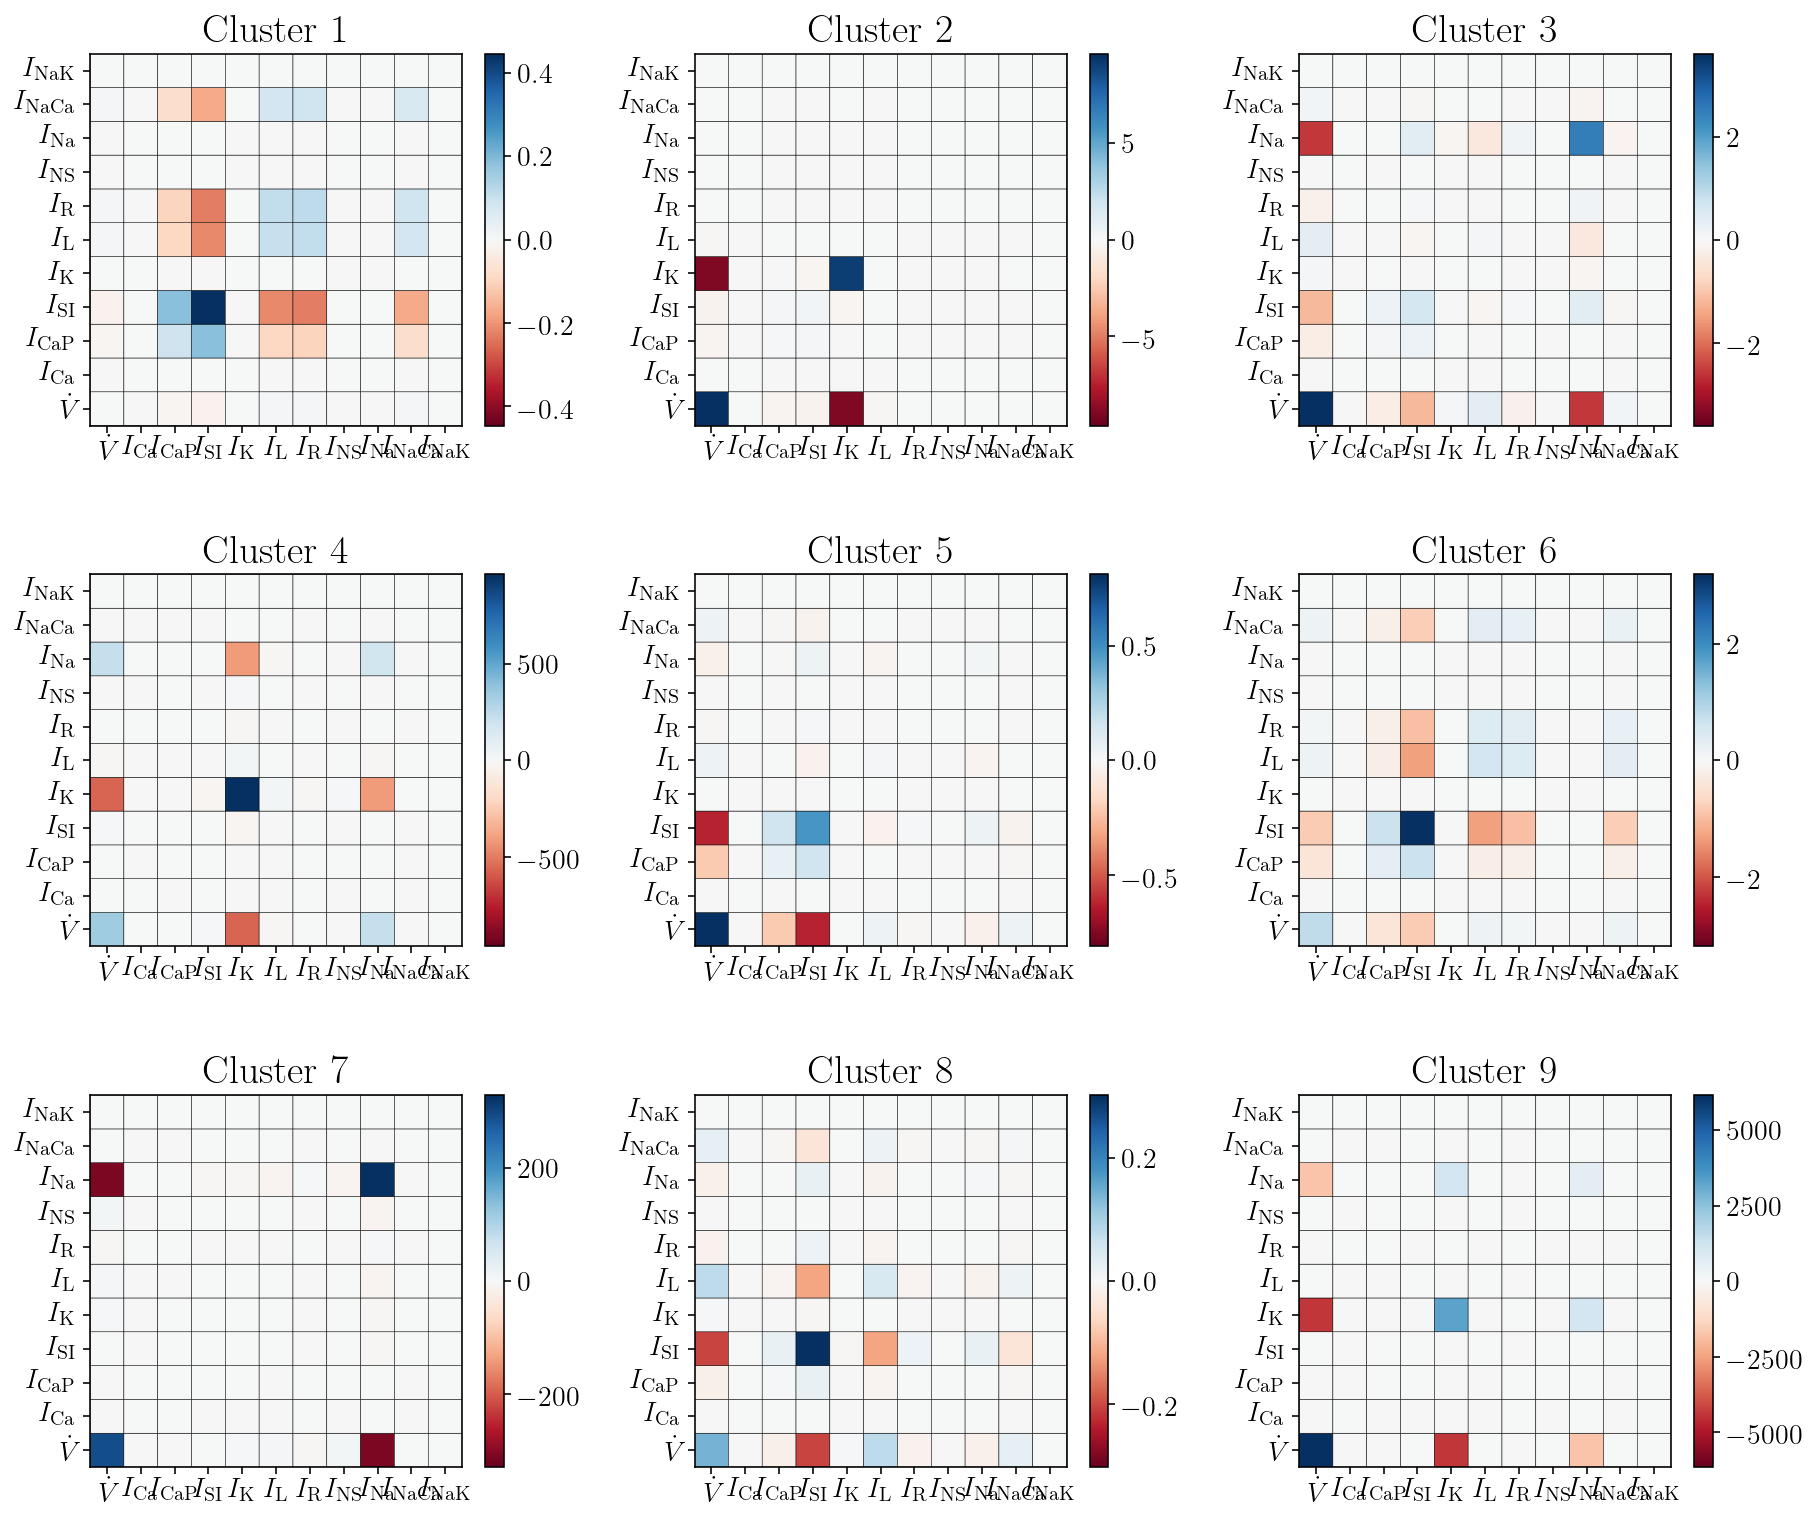

In [23]:
## Plot covariance matrices
plt.figure(figsize=(15, 13))
for i in range(nc):
    plt.subplot(3, 3, i+1)
    C = model.covariances_[i, :, :]
    plt.pcolor(C, vmin=-max(abs(C.flatten())), vmax=max(abs(C.flatten())), cmap='RdBu', edgecolors='k')
    plt.gca().set_xticks(np.arange(0.5, nfeatures+0.5))
    plt.gca().set_xticklabels(labels)
    plt.gca().set_yticks(np.arange(0.5, nfeatures+0.5))
    plt.gca().set_yticklabels(labels)
    plt.gca().set_title('Cluster {0}'.format(i+1))
    plt.colorbar()
    
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)
plt.show()

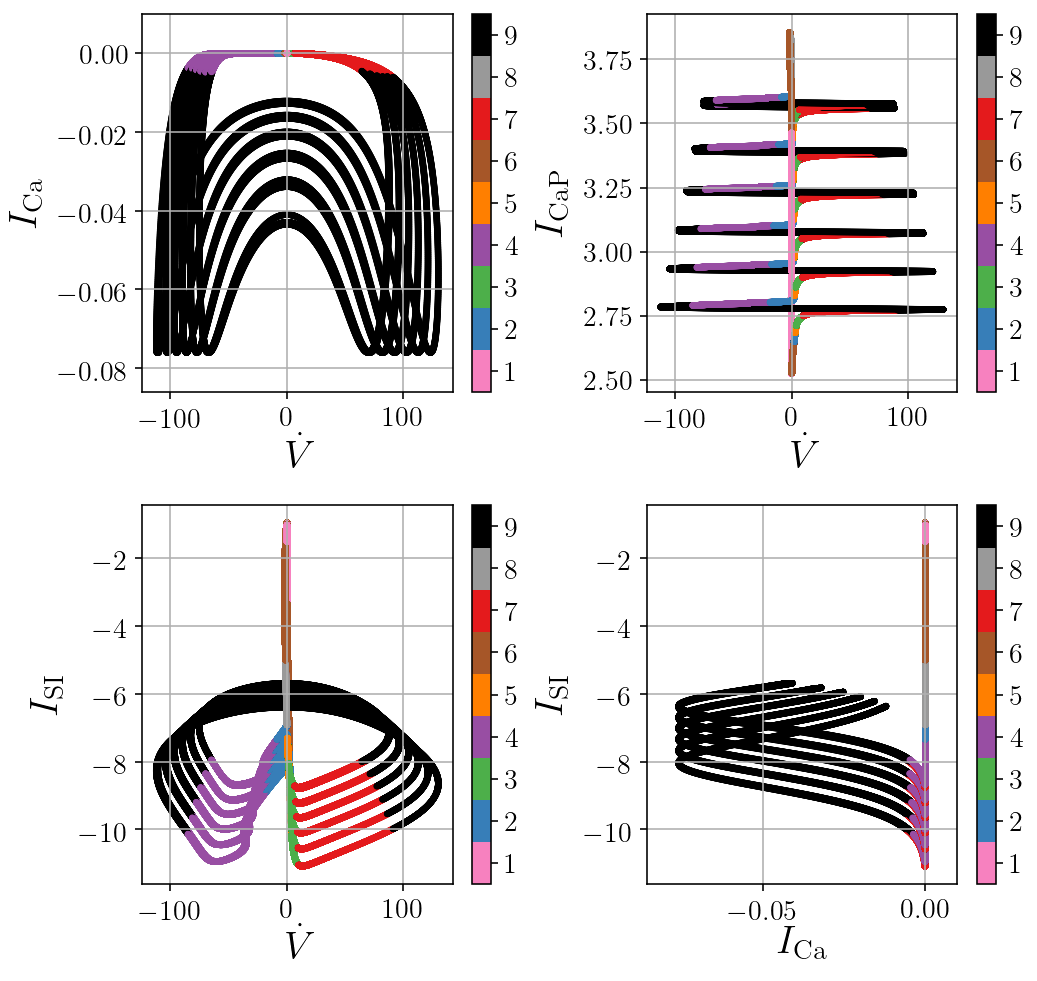

In [26]:
# Equation space, colored by GMM clusters

plt.figure(figsize=(8, 8))

plt.subplot(221)
plt.scatter(features[:, 0], features[:, 1], s, cluster_idx+1, cmap=cm)
plt.xlabel(labels[0])
plt.ylabel(labels[1])
plt.grid()
plt.clim([-0.5, cm.N-0.5])
plt.colorbar(boundaries=np.arange(0.5, nc+1.5), ticks=np.arange(0, nc+1))

plt.subplot(222)
plt.scatter(features[:, 0], features[:, 2], s, cluster_idx+1, cmap=cm)
plt.xlabel(labels[0])
plt.ylabel(labels[2])
plt.grid()
plt.clim([-0.5, cm.N-0.5])
plt.colorbar(boundaries=np.arange(0.5, nc+1.5), ticks=np.arange(0, nc+1))

plt.subplot(223)
plt.scatter(features[:, 0], features[:, 3], s, cluster_idx+1, cmap=cm)
plt.xlabel(labels[0])
plt.ylabel(labels[3])
plt.grid()
plt.clim([-0.5, cm.N-0.5])
plt.colorbar(boundaries=np.arange(0.5, nc+1.5), ticks=np.arange(0, nc+1))

plt.subplot(224)
plt.scatter(features[:, 1], features[:, 3], s, cluster_idx+1, cmap=cm)
plt.xlabel(labels[1])
plt.ylabel(labels[3])
plt.grid()
plt.clim([-0.5, cm.N-0.5])
plt.colorbar(boundaries=np.arange(0.5, nc+1.5), ticks=np.arange(0, nc+1))

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

# 3. SPCA reduction

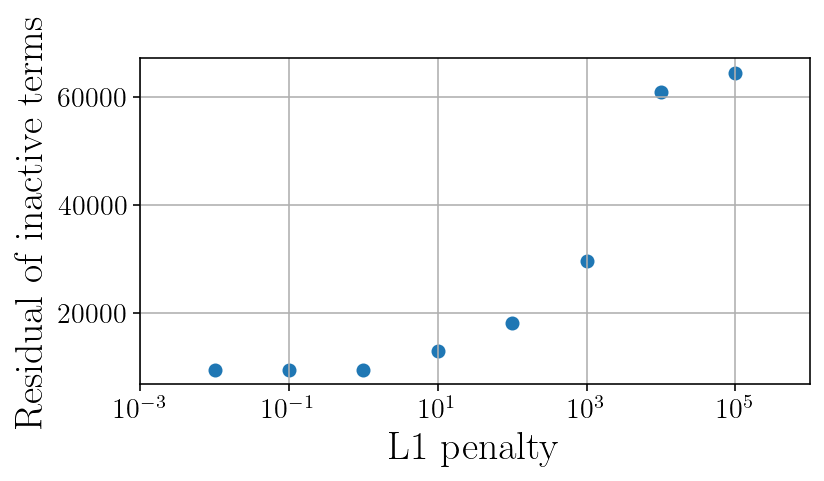

In [27]:
# Sparse PCA to identify directions of nonzero variance
#   First step: model selection for L1 regularization
alphas = [1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5]
err = np.zeros([len(alphas)])  # Error defined as norm of inactive terms
sparsity = np.zeros([len(alphas)])

for k in range(len(alphas)):
    for i in range(nc):
        
        # Identify points in the field corresponding to each cluster
        feature_idx = np.nonzero(cluster_idx==i)[0]
        cluster_features = features[feature_idx, :]
        spca = SparsePCA(n_components=1, alpha=alphas[k], normalize_components=True)
        spca.fit(cluster_features)
        active_terms = np.nonzero(spca.components_[0])[0]
        inactive_terms = [feat for feat in range(nfeatures) if feat not in active_terms ]
        
        #err[k] += np.linalg.norm(np.linalg.norm(np.sum(cluster_features[:, inactive_terms], axis=0)))
        err[k] += np.linalg.norm(cluster_features[:, inactive_terms])
        
plt.figure(figsize=(6, 3))
plt.scatter(alphas, err)
plt.xlabel('L1 penalty')
plt.ylabel('Residual of inactive terms')
plt.gca().set_xscale('log')
plt.xlim([1e-3, 1e6])
plt.grid()
plt.show()

In [28]:
# Sparse PCA to identify directions of nonzero variance

alpha_opt = 100

spca_model = np.zeros([nc, nfeatures])
for i in range(nc):
    feature_idx = np.nonzero(cluster_idx==i)[0]
    cluster_features = features[feature_idx, :]
    
    spca = SparsePCA(n_components=1, alpha=alpha_opt, normalize_components=True)
    spca.fit(cluster_features)
    print('GMM Cluster {0}:'.format(i+1))
    active_terms = np.nonzero(spca.components_[0])[0]
    if len(active_terms)>0:
        print([labels[k] for k in active_terms])
        spca_model[i, active_terms] = 1  # Set to 1 for active terms in model
    else: print('None')

GMM Cluster 1:
['$I_\\mathrm{CaP}$', '$I_\\mathrm{SI}$', '$I_\\mathrm{L}$', '$I_\\mathrm{R}$', '$I_\\mathrm{NaCa}$']
GMM Cluster 2:
['$\\dot{V}$', '$I_\\mathrm{K}$']
GMM Cluster 3:
['$\\dot{V}$', '$I_\\mathrm{SI}$', '$I_\\mathrm{Na}$']
GMM Cluster 4:
['$\\dot{V}$', '$I_\\mathrm{K}$', '$I_\\mathrm{L}$', '$I_\\mathrm{Na}$']
GMM Cluster 5:
['$\\dot{V}$', '$I_\\mathrm{SI}$']
GMM Cluster 6:
['$\\dot{V}$', '$I_\\mathrm{CaP}$', '$I_\\mathrm{SI}$', '$I_\\mathrm{L}$', '$I_\\mathrm{R}$', '$I_\\mathrm{NaCa}$']
GMM Cluster 7:
['$\\dot{V}$', '$I_\\mathrm{Na}$']
GMM Cluster 8:
['$\\dot{V}$', '$I_\\mathrm{SI}$']
GMM Cluster 9:
['$\\dot{V}$', '$I_\\mathrm{K}$', '$I_\\mathrm{Na}$']


# 4. Final dominant balance models

In [29]:
# balance_models has ones for active terms in each model
# model_index maps from GMM identification to the SPCA model
balance_models, model_index = np.unique(spca_model, axis=0, return_inverse=True)
nmodels = balance_models.shape[0]
print(balance_models)

for i in range(nmodels):
    print('SPCA Cluster {0}:'.format(i))
    active_terms = np.nonzero(balance_models[i, :])[0]
    if len(active_terms)>0:
        print([labels[k] for k in active_terms])
    else: print('No dynamics')

# Make new cluster_idx based on SPCA balance model
balance_idx = np.array([model_index[i] for i in cluster_idx])

[[0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0.]]
SPCA Cluster 0:
['$I_\\mathrm{CaP}$', '$I_\\mathrm{SI}$', '$I_\\mathrm{L}$', '$I_\\mathrm{R}$', '$I_\\mathrm{NaCa}$']
SPCA Cluster 1:
['$\\dot{V}$', '$I_\\mathrm{Na}$']
SPCA Cluster 2:
['$\\dot{V}$', '$I_\\mathrm{K}$']
SPCA Cluster 3:
['$\\dot{V}$', '$I_\\mathrm{K}$', '$I_\\mathrm{Na}$']
SPCA Cluster 4:
['$\\dot{V}$', '$I_\\mathrm{K}$', '$I_\\mathrm{L}$', '$I_\\mathrm{Na}$']
SPCA Cluster 5:
['$\\dot{V}$', '$I_\\mathrm{SI}$']
SPCA Cluster 6:
['$\\dot{V}$', '$I_\\mathrm{SI}$', '$I_\\mathrm{Na}$']
SPCA Cluster 7:
['$\\dot{V}$', '$I_\\mathrm{CaP}$', '$I_\\mathrm{SI}$', '$I_\\mathrm{L}$', '$I_\\mathrm{R}$', '$I_\\mathrm{NaCa}$']


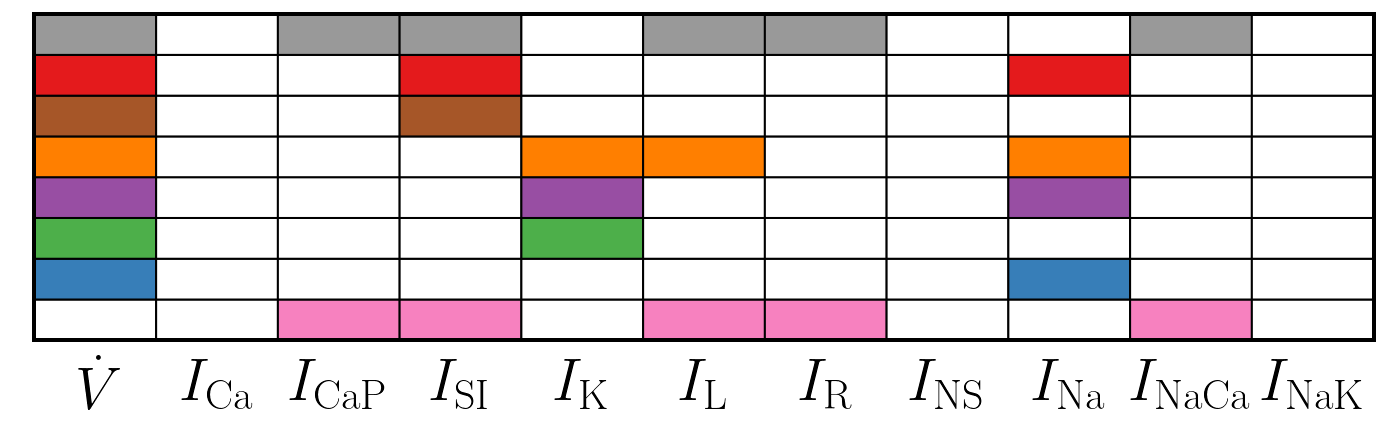

In [31]:
gridmap = balance_models.copy()
#gridmap[gridmap==0] = np.NaN
gridmap = (gridmap.T*np.arange(1, nmodels+1)).T  # Scale map so that active terms can be color-coded

plt.figure(figsize=(12, 3))
plt.pcolor(gridmap, vmin=-0.5, vmax=cm.N-0.5, cmap=cm, edgecolors='k', linewidth=1)
plt.gca().set_xticks(np.arange(0.5, nfeatures+0.5))
plt.gca().set_xticklabels(labels, fontsize=30)
plt.gca().set_yticks([])

for axis in ['top','bottom','left','right']:
    plt.gca().spines[axis].set_linewidth(2)
    
plt.gca().tick_params(axis='both', width=0, length=10)
plt.savefig('fig.eps', bbox_inches='tight')
plt.show()

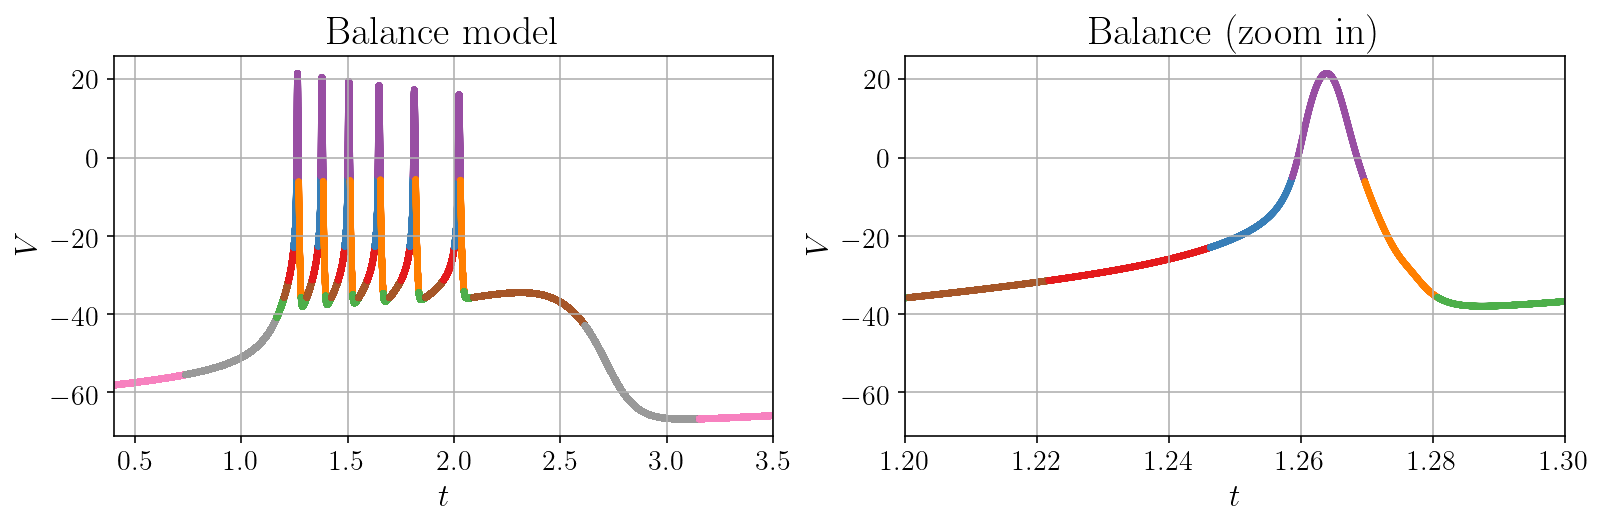

In [32]:
s=5

plot_idx = (t<1.3)*(t>1.2)

plt.figure(figsize=(13, 3.5))

plt.subplot(121)
plot_idx = (t<3.5)*(t>0.4)
plt.scatter(t[plot_idx], V[plot_idx], s, balance_idx[plot_idx]+1, cmap=cm)
plt.clim([-0.5, cm.N-0.5])
plt.xlim([0.4, 3.5])

plt.xlabel('$t$', fontsize=16)
plt.ylabel(r'$V$', fontsize=16)
plt.title('Balance model')
plt.grid()

plt.subplot(122)
plt.scatter(t[plot_idx], V[plot_idx], s, balance_idx[plot_idx]+1, cmap=cm)
plt.clim([-0.5, cm.N-0.5])
plt.xlim([1.2, 1.3])

plt.xlabel('$t$', fontsize=16)
plt.ylabel(r'$V$', fontsize=16)
plt.grid()
plt.title('Balance (zoom in)')

plt.show()

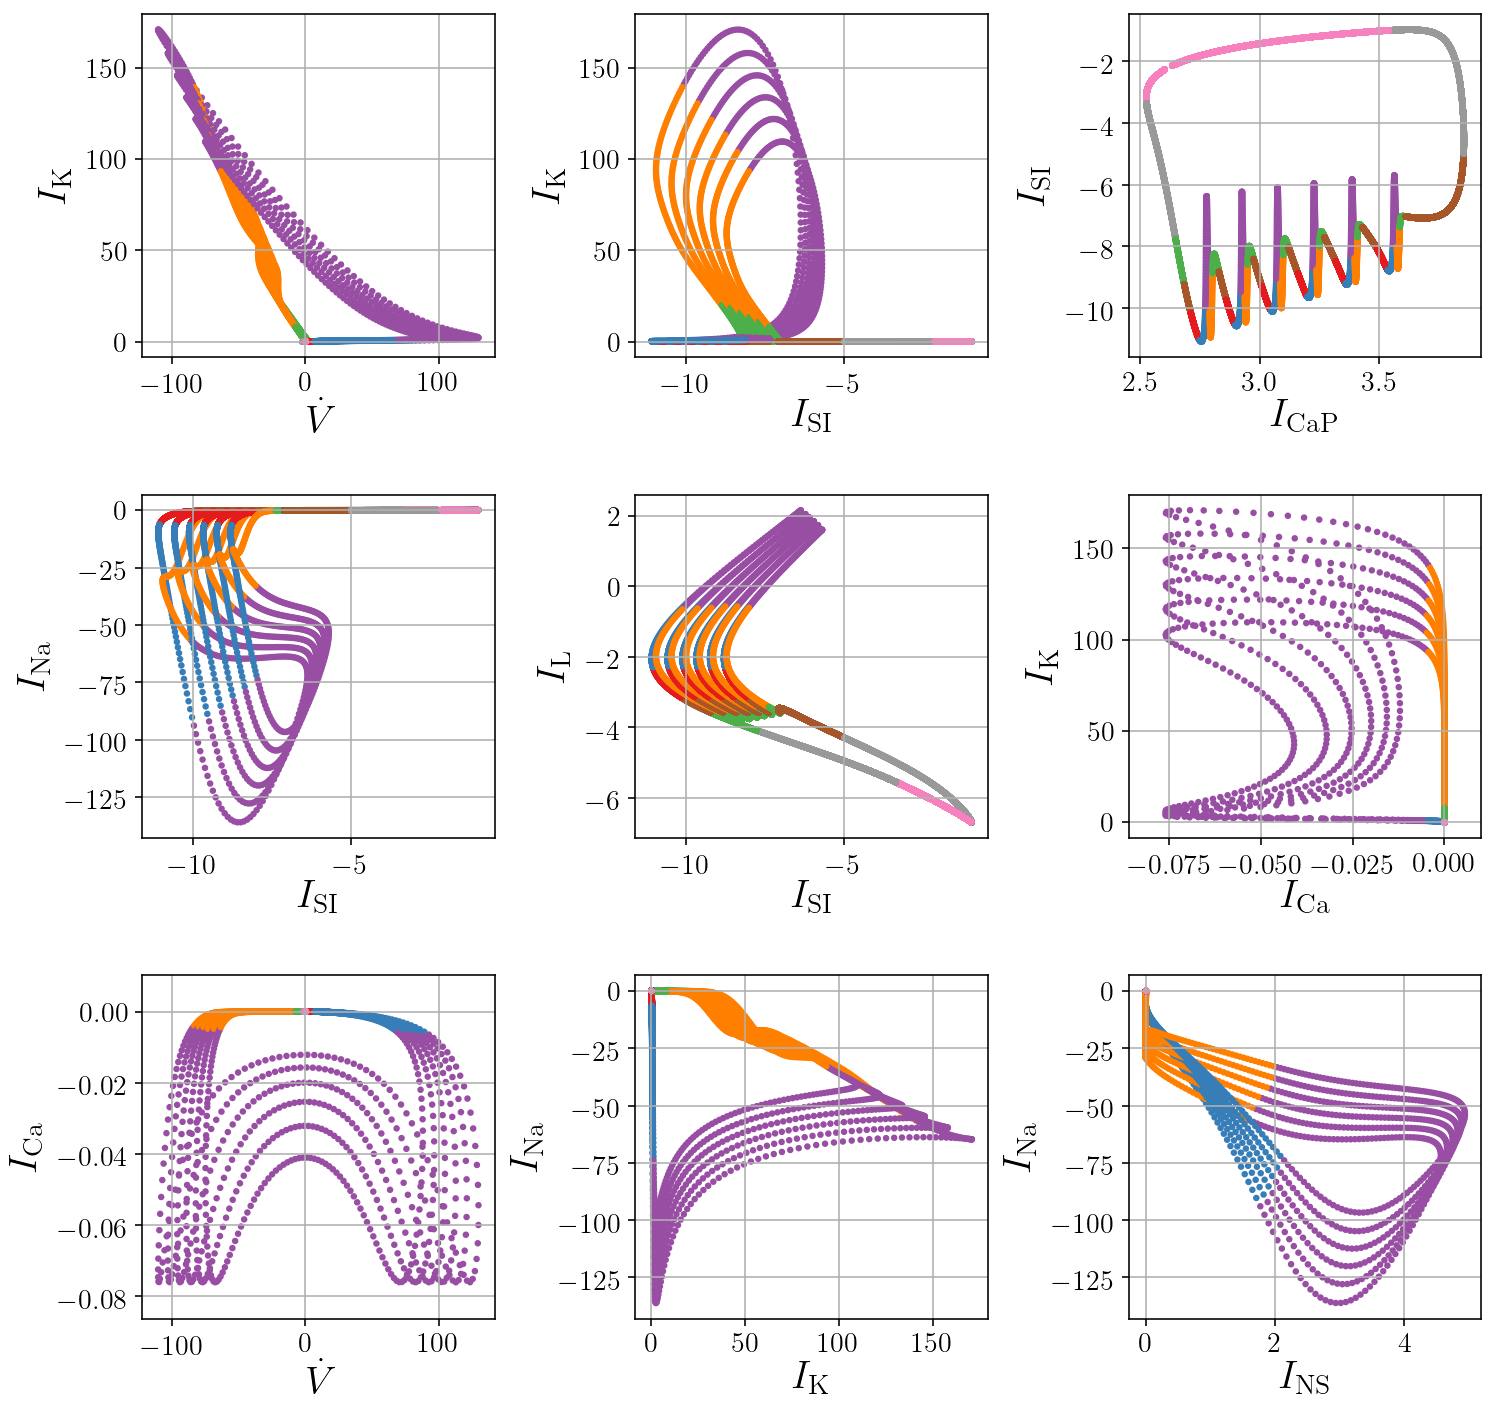

In [35]:
# "Predict" clusters
s=5
# Equation space terms

plt_idx = np.nonzero(t<5)[0][::10]

plt.figure(figsize=(12, 12))

plt.subplot(331)
plt.scatter(features[plt_idx, 0], features[plt_idx, 4], s, balance_idx[plt_idx]+1, cmap=cm)
plt.xlabel(labels[0])
plt.ylabel(labels[4])
plt.grid()
plt.clim([-0.5, cm.N-0.5])
#plt.colorbar(boundaries=np.arange(0.5, nmodels+1.5), ticks=np.arange(0, nmodels+1))

plt.subplot(332)
plt.scatter(features[plt_idx, 3], features[plt_idx, 4], s, balance_idx[plt_idx]+1, cmap=cm)
plt.xlabel(labels[3])
plt.ylabel(labels[4])
plt.grid()
plt.clim([-0.5, cm.N-0.5])
#plt.colorbar(boundaries=np.arange(0.5, nmodels+1.5), ticks=np.arange(0, nmodels+1))

plt.subplot(333)
plt.scatter(features[plt_idx, 2], features[plt_idx, 3], s, balance_idx[plt_idx]+1, cmap=cm)
plt.xlabel(labels[2])
plt.ylabel(labels[3])
plt.grid()
plt.clim([-0.5, cm.N-0.5])
#plt.colorbar(boundaries=np.arange(0.5, nmodels+1.5), ticks=np.arange(0, nmodels+1))

plt.subplot(334)
plt.scatter(features[plt_idx, 3], features[plt_idx, 8], s, balance_idx[plt_idx]+1, cmap=cm)
plt.xlabel(labels[3])
plt.ylabel(labels[8])
plt.grid()
plt.clim([-0.5, cm.N-0.5])
#plt.colorbar(boundaries=np.arange(0.5, nmodels+1.5), ticks=np.arange(0, nmodels+1))

plt.subplot(335)
plt.scatter(features[plt_idx, 3], features[plt_idx, 5], s, balance_idx[plt_idx]+1, cmap=cm)
plt.xlabel(labels[3])
plt.ylabel(labels[5])
plt.grid()
plt.clim([-0.5, cm.N-0.5])
#plt.colorbar(boundaries=np.arange(0.5, nmodels+1.5), ticks=np.arange(0, nmodels+1))

plt.subplot(336)
plt.scatter(features[plt_idx, 1], features[plt_idx, 4], s, balance_idx[plt_idx]+1, cmap=cm)
plt.xlabel(labels[1])
plt.ylabel(labels[4])
plt.grid()
plt.clim([-0.5, cm.N-0.5])
#plt.colorbar(boundaries=np.arange(0.5, nmodels+1.5), ticks=np.arange(0, nmodels+1))

plt.subplot(337)
plt.scatter(features[plt_idx, 0], features[plt_idx, 1], s, balance_idx[plt_idx]+1, cmap=cm)
plt.xlabel(labels[0])
plt.ylabel(labels[1])
plt.grid()
plt.clim([-0.5, cm.N-0.5])
#plt.colorbar(boundaries=np.arange(0.5, nmodels+1.5), ticks=np.arange(0, nmodels+1))

plt.subplot(338)
plt.scatter(features[plt_idx, 4], features[plt_idx, 8], s, balance_idx[plt_idx]+1, cmap=cm)
plt.xlabel(labels[4])
plt.ylabel(labels[8])
plt.grid()
plt.clim([-0.5, cm.N-0.5])
#plt.colorbar(boundaries=np.arange(0.5, nmodels+1.5), ticks=np.arange(0, nmodels+1))

plt.subplot(339)
plt.scatter(features[plt_idx, 7], features[plt_idx, 8], s, balance_idx[plt_idx]+1, cmap=cm)
plt.xlabel(labels[7])
plt.ylabel(labels[8])
plt.grid()
plt.clim([-0.5, cm.N-0.5])
#plt.colorbar(boundaries=np.arange(0.5, nmodels+1.5), ticks=np.arange(0, nmodels+1))

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()